# Sea Ice Extent Timeseries
## **SOSE**

In [3]:
! mamba install "xgcm<0.7.0" -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.25.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ["xgcm[version='<0.7.0']"]

conda-forge/linux-64                                        Using cache

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.310258fc3a7146b79ea1e3b88627b36a/status,


In [79]:
client.close()
cluster.close()

In [4]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [5]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

mapping = fs.get_mapper('gcs://pangeo-ecco-sose')

ds = xr.open_zarr(mapping, consolidated=True)

coordsr = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables

In [15]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lat_range_u = dict(YG=slice(lower_lat, upper_lat+1))
lon_range_u = dict(XG=slice(left_lon, right_lon+1))

coords_untrue = coordsr.roll(XC=700, XG=700).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
coords = coordsr.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds = dsr.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

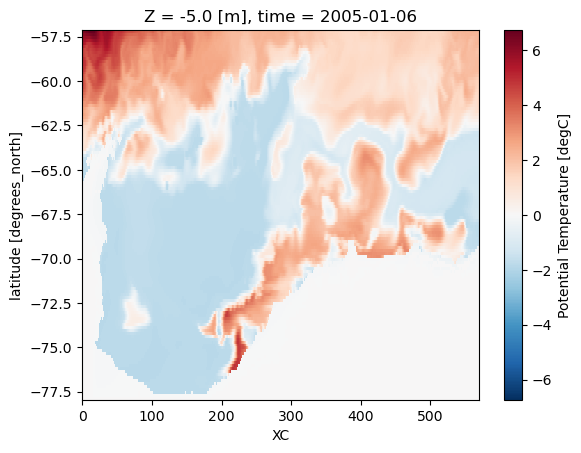

In [8]:
ds.THETA[0,0].drop('XC').plot()

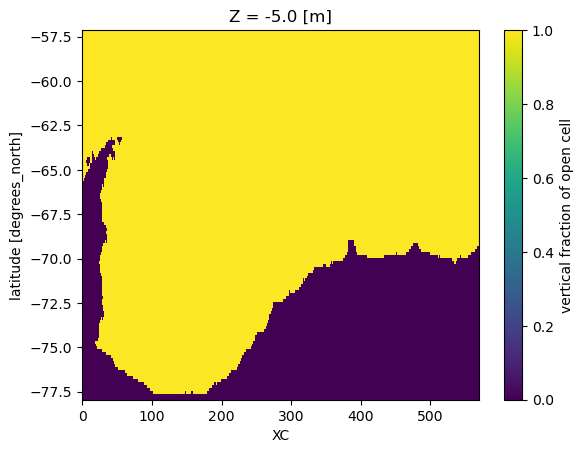

In [9]:
coords.hFacC[0].drop('XC').plot()

In [10]:
mask = (coords.hFacC[0]>0)

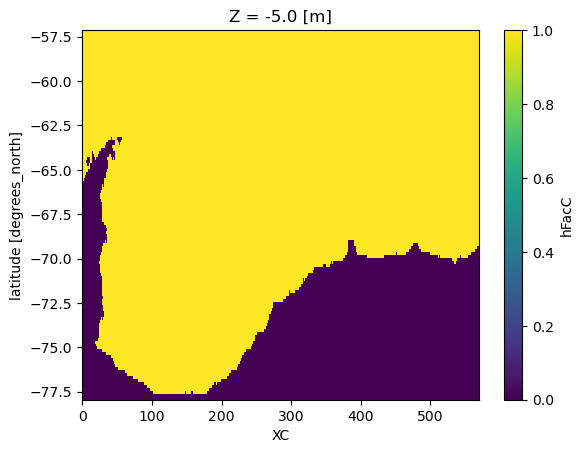

In [11]:
mask.drop('XC').plot()

In [12]:
ds.SIarea

<xarray.DataArray 'SIarea' (time: 438, YC: 125, XC: 570)>
dask.array<getitem, shape=(438, 125, 570), dtype=float32, chunksize=(1, 125, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

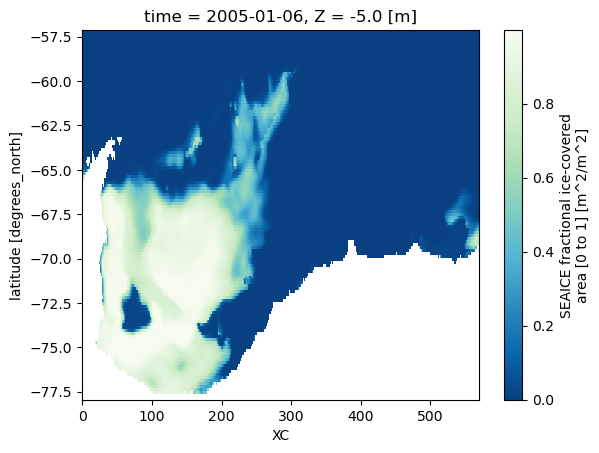

In [14]:
ds.SIarea[0].where(mask).drop('XC').plot(cmap='GnBu_r')

In [16]:
lon = coords.XC
lat = coords.YC
msi = ds.SIarea.where(mask).mean(dim='time').load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


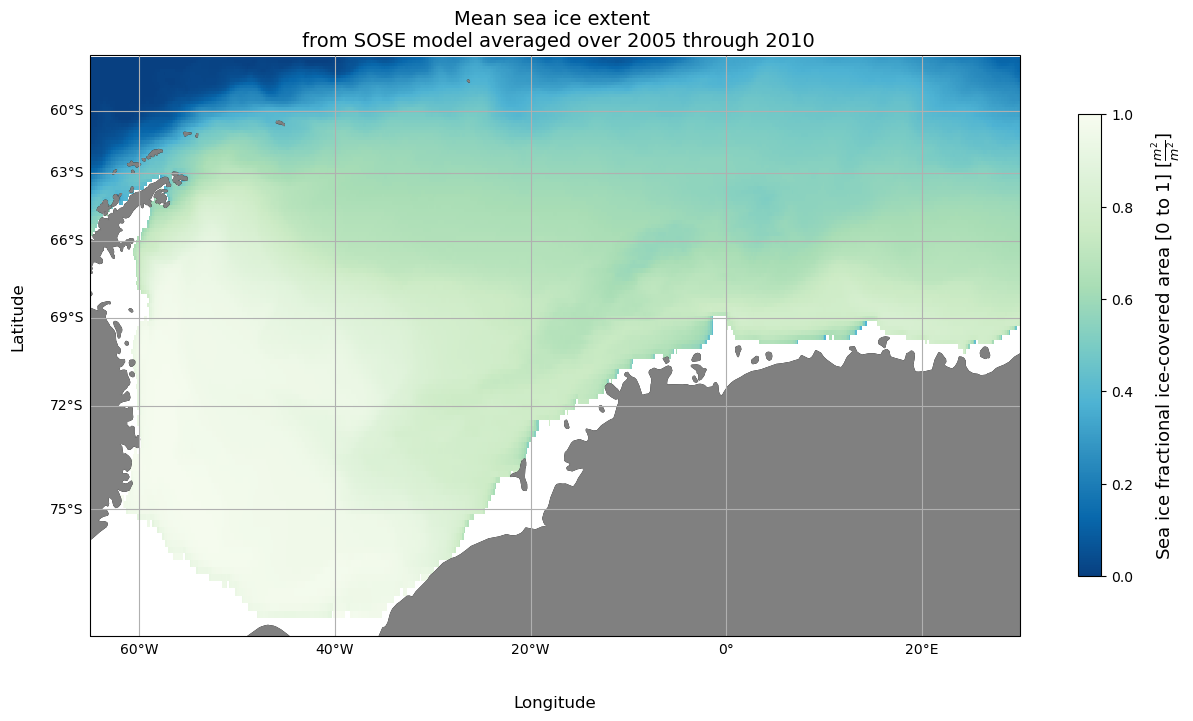

In [17]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, msi, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Sea ice fractional ice-covered area [0 to 1] $[\frac{m^2}{m^2}]$", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Mean sea ice extent \n from SOSE model averaged over 2005 through 2010', fontsize=14);

In [18]:
msi_06to10 = ds.SIarea.sel(time=slice('2006', '2010')).where(mask).mean(dim='time').load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


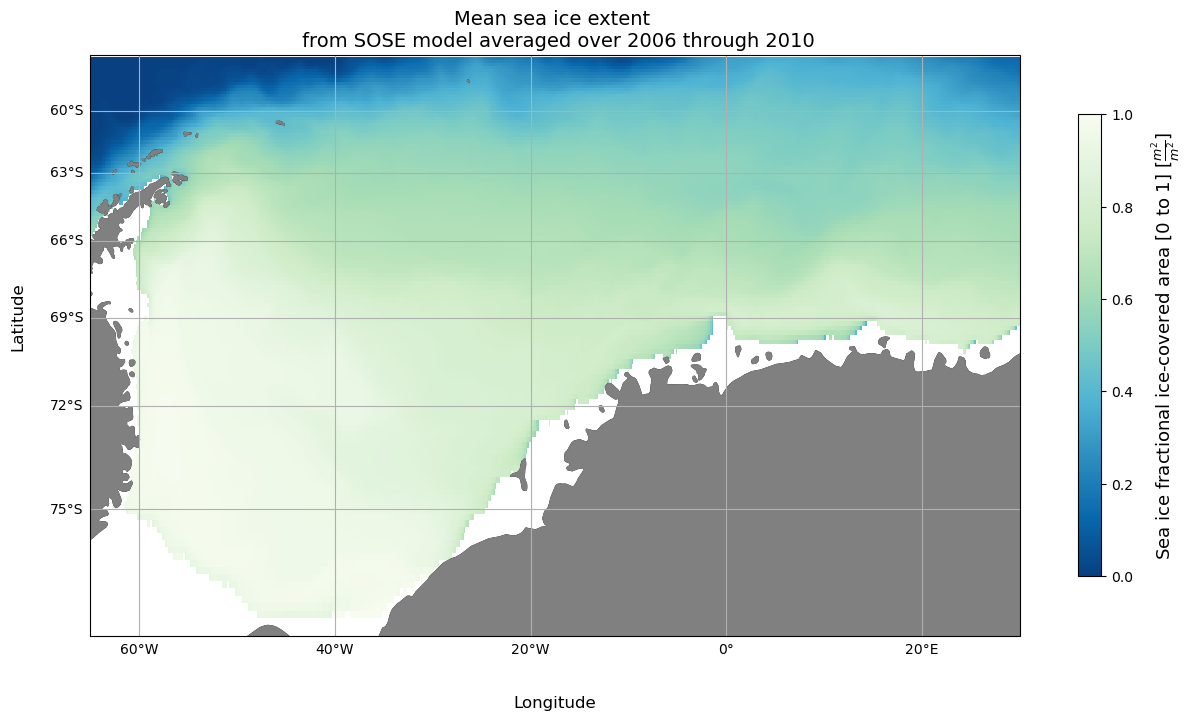

In [19]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, msi_06to10, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Sea ice fractional ice-covered area [0 to 1] $[\frac{m^2}{m^2}]$", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Mean sea ice extent \n from SOSE model averaged over 2006 through 2010', fontsize=14);

In [20]:
seaice = ds.SIarea.where(mask)
seaice_no05 = ds.SIarea.sel(time=slice('2006', '2010')).where(mask)

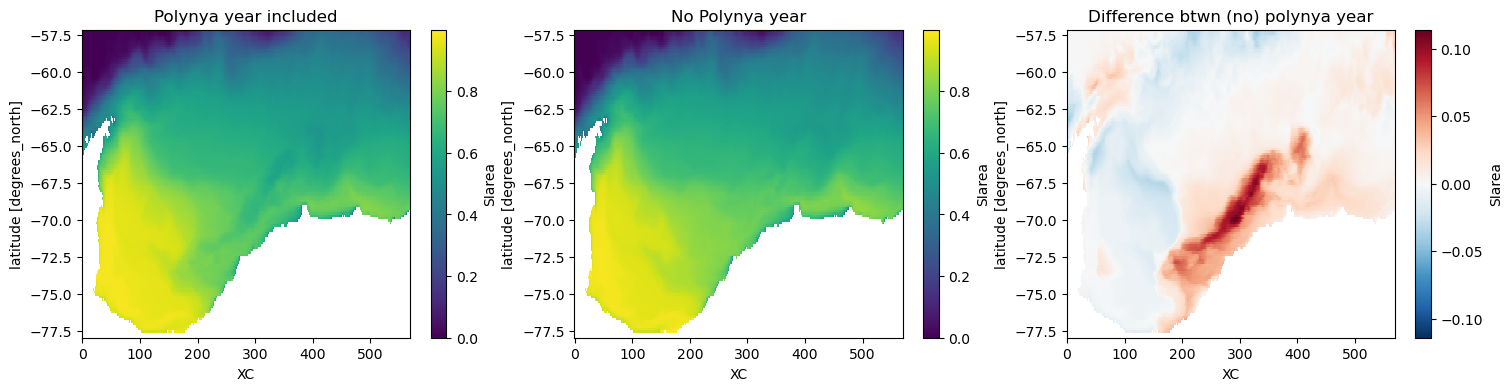

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18,4))

seaice.mean('time').drop('XC').plot(ax=ax0)
seaice_no05.mean('time').drop('XC').plot(ax=ax1)
(seaice_no05.mean('time') - seaice.mean('time')).drop('XC').plot(ax=ax2)
ax0.set_title('Polynya year included')
ax1.set_title('No Polynya year')
ax2.set_title('Difference btwn (no) polynya year');

In [23]:
seaice_no05

<xarray.DataArray 'SIarea' (time: 366, YC: 125, XC: 570)>
dask.array<where, shape=(366, 125, 570), dtype=float32, chunksize=(1, 125, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

In [24]:
area = coords.rA
weighted_area = seaice_no05 * area

In [25]:
weighted_area

<xarray.DataArray (time: 366, YC: 125, XC: 570)>
dask.array<mul, shape=(366, 125, 570), dtype=float32, chunksize=(1, 125, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0

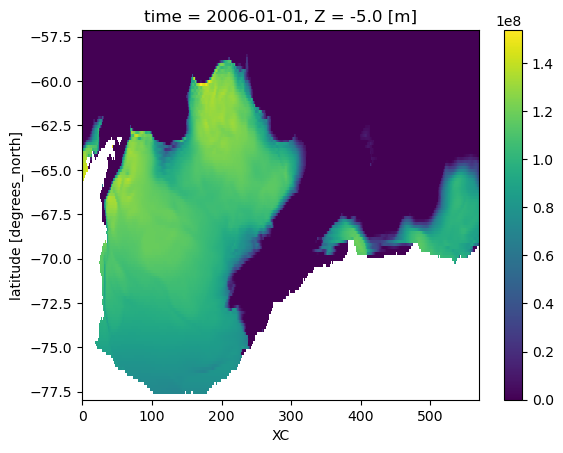

In [26]:
weighted_area[0].drop('XC').plot()

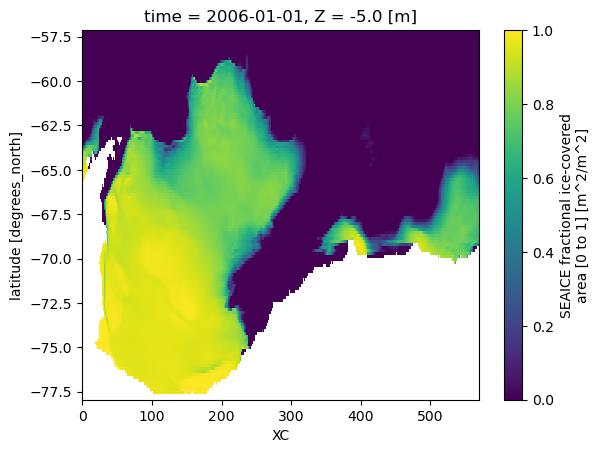

In [27]:
seaice_no05[0].drop('XC').plot()

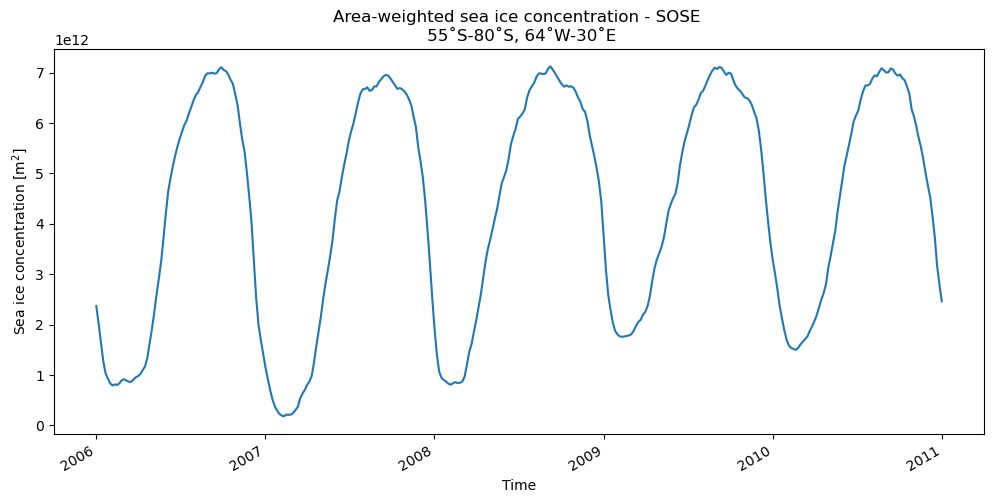

In [28]:
plt.figure(figsize=(12,5))
weighted_area.sum(['XC', 'YC']).plot()
plt.title('Area-weighted sea ice concentration - SOSE \n 55˚S-80˚S, 64˚W-30˚E')
plt.ylabel(r'Sea ice concentration [m$^2$]');

In [29]:
ice_anom = weighted_area.groupby('time.month') - weighted_area.groupby('time.month').mean()
ice_anom

<xarray.DataArray (time: 366, YC: 125, XC: 570)>
dask.array<sub, shape=(366, 125, 570), dtype=float32, chunksize=(1, 125, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        (time) float32 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

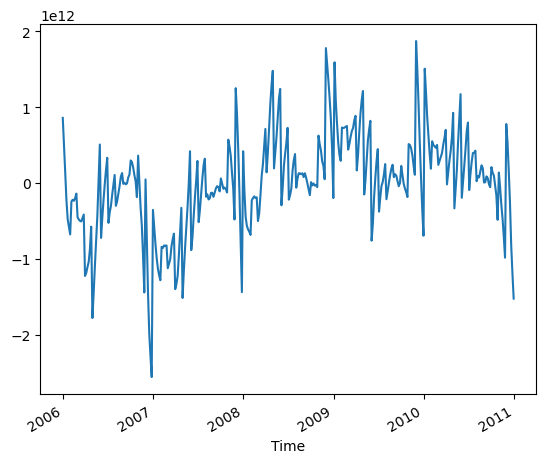

In [30]:
ice_anom.sum(['YC', 'XC']).plot()

In [31]:
si_index = ice_anom.sum(['YC', 'XC'])/ ice_anom.sum(['YC', 'XC']).std(dim='time')
si_index

<xarray.DataArray (time: 366)>
dask.array<truediv, shape=(366,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        (time) float32 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

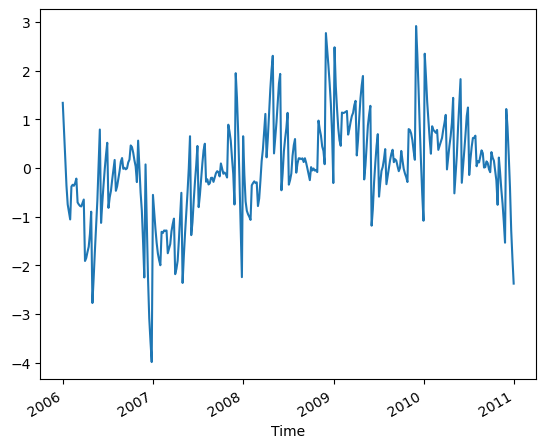

In [32]:
si_index.plot()

## SAM Index

In [37]:
url_ann = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/ann-seas-sam-57-07.csv'
ann_seas = pd.read_csv(url_ann, delim_whitespace=True, parse_dates=True, )
url_mo = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/mo-sam-57-07.csv'
mo = pd.read_csv(url_mo, delim_whitespace=True, parse_dates=True)

In [38]:
ann_seas.index = ann_seas.index.rename('time')
mo.index = mo.index.rename('time')

In [39]:
mo

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
time,,,,,,,,,,,,
1957-01-01,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958-01-01,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959-01-01,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960-01-01,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961-01-01,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018-01-01,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019-01-01,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78


In [40]:
#flattening dataframe by having next row go after the prev row, instead of col going after col
time = pd.date_range('1/1957', '1/2022', freq='M')
vector = np.array(mo.iloc[0])
for i in range(1,65):
    new_vec = np.array(mo.iloc[i])
    vector = np.append(vector,new_vec)

In [41]:
mo_xr = xr.DataArray(vector, coords=[time.rename('time')])

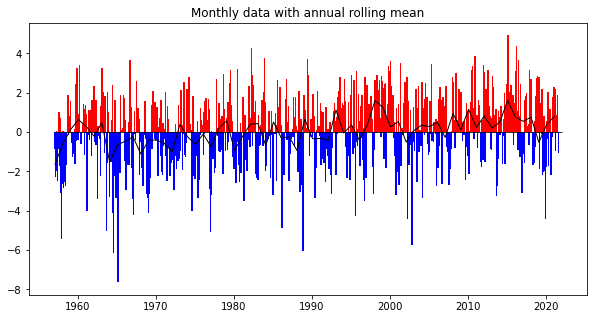

In [42]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.bar(time[np.where(mo_xr<0)], mo_xr.where(mo_xr < 0).dropna(dim='time'), color='b', width=70)
ax.bar(time[np.where(mo_xr>=0)], mo_xr.where(mo_xr >= 0).dropna(dim='time'), color='r', width=70)
ax.hlines(0, time[0], time[-1], colors='k', linewidth=0.8)
#mo_xr.rolling(time=12).mean().plot(color='k', linewidth=1)
plt.plot(time.values[np.arange(0, 780, 12)], mo_xr.groupby('time.year').mean().values, color='k', linewidth=1)
#mo_xr.groupby('time.year').mean().plot(color='k', linewidth=1)
plt.title('Monthly data with annual rolling mean');

## SAM & sea ice corr

In [43]:
seaice_no05.sum(['XC', 'YC'])

<xarray.DataArray 'SIarea' (time: 366)>
dask.array<sum-aggregate, shape=(366,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0

In [44]:
ann_seas.ANN.loc['2006':'2011']

time
2006-01-01    1.51
2007-01-01   -0.77
2008-01-01    2.28
2009-01-01    0.22
2010-01-01    3.28
2011-01-01    0.79
Name: ANN, dtype: float64

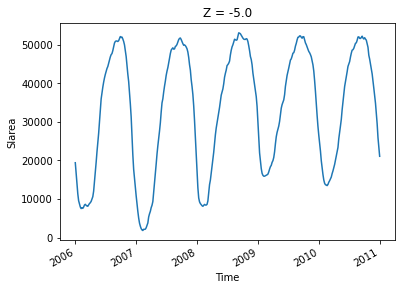

In [45]:
seaice_no05.sum(['XC', 'YC']).plot()
#ann_seas.ANN.loc['2006':'2011'].plot();

<AxesSubplot:xlabel='time'>

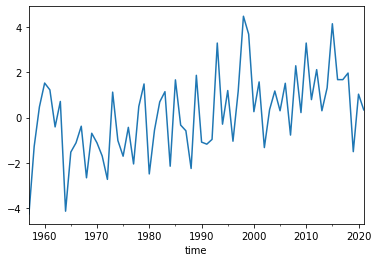

In [46]:
ann_seas.ANN.plot()

<AxesSubplot:xlabel='time'>

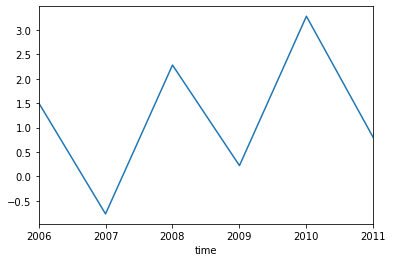

In [47]:
ann_seas.ANN.loc['2006':'2011'].plot()

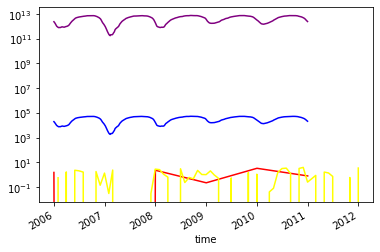

In [48]:
seaice_no05.sum(['XC', 'YC']).plot(color='blue')
weighted_area.sum(['XC', 'YC']).plot(color='purple')
ann_seas.ANN.loc['2006':'2011'].plot(color='red')
mo_xr.sel(time=slice('2006', '2011')).plot(color='yellow')
plt.yscale('log')

In [49]:
seaice_no05.sum(['XC', 'YC'])

<xarray.DataArray 'SIarea' (time: 366)>
dask.array<sum-aggregate, shape=(366,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0

In [50]:
mo_xr.sel(time=slice('2006', '2011'))

<xarray.DataArray (time: 72)>
array([ 0.56, -1.85,  1.66, -0.69,  2.28,  2.05,  1.61, -2.64, -0.26,
        1.79,  0.14,  1.34,  0.03,  2.36, -0.77, -0.33, -1.02, -0.65,
       -2.67, -0.28, -1.88, -0.86,  0.03,  2.8 ,  2.56,  1.09,  0.63,
       -0.81, -0.66,  3.  ,  0.23,  0.6 ,  0.46,  2.21,  1.03,  1.01,
        2.02,  0.94,  0.5 , -0.43, -0.14,  0.54, -0.13, -2.44, -0.78,
        1.47, -1.2 ,  1.09, -0.4 , -2.12,  0.04,  0.08,  1.51,  3.14,
        3.37,  1.24, -0.33,  3.19,  3.88,  0.25,  0.48,  0.87, -0.79,
        1.62,  1.37,  0.72, -1.52, -0.73, -1.79,  0.59, -1.41,  3.43])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-31 2006-02-28 ... 2011-12-31

In [51]:
mo_xr.time

<xarray.DataArray 'time' (time: 780)>
array(['1957-01-31T00:00:00.000000000', '1957-02-28T00:00:00.000000000',
       '1957-03-31T00:00:00.000000000', ..., '2021-10-31T00:00:00.000000000',
       '2021-11-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1957-01-31 1957-02-28 ... 2021-12-31

<AxesSubplot:xlabel='time'>

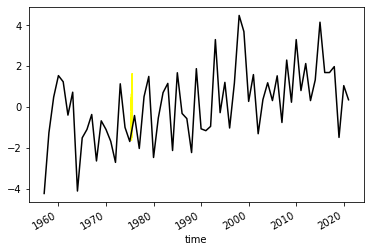

In [52]:
mo_xr.groupby('time.year').mean().plot(color='yellow')
ann_seas.ANN.plot(color='k')

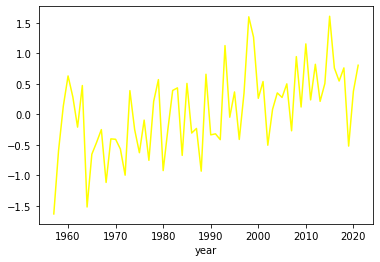

In [53]:
mo_xr.groupby('time.year').mean().plot(color='yellow')

In [54]:
no_seas = mo_xr.groupby('time.month') - mo_xr.groupby('time.month').mean(dim='time')
no_seas

<xarray.DataArray (time: 780)>
array([-1.25769231e+00, -1.95384615e+00,  7.55384615e-02, -2.11984615e+00,
       -2.40630769e+00, -1.11353846e+00,  9.19846154e-01, -1.66546875e+00,
        6.57343750e-01, -3.14296875e+00, -5.39859375e+00, -2.78375000e+00,
       -3.47692308e-01, -2.52384615e+00, -2.51446154e+00, -4.49846154e-01,
       -2.62630769e+00, -1.21353846e+00, -1.73015385e+00,  1.03453125e+00,
        1.83734375e+00, -1.82968750e-01,  3.21406250e-01,  6.66250000e-01,
        1.20230769e+00,  1.26153846e-01, -5.34461538e-01, -1.39984615e+00,
       -2.26307692e-01, -1.36353846e+00,  9.98461538e-02, -1.57546875e+00,
        2.39734375e+00, -4.82968750e-01,  3.30140625e+00, -5.33750000e-01,
        5.12307692e-01,  1.16615385e+00,  3.40553846e+00, -4.99846154e-01,
       -5.06307692e-01, -4.13538462e-01,  2.29846154e-01,  4.94531250e-01,
        1.34734375e+00, -1.19296875e+00,  1.20140625e+00,  1.20625000e+00,
        5.22307692e-01, -3.68384615e+00, -3.94461538e-01, -2.89846154e-01,
        1.21369231e+00, -6.43538462e-01,  8.99846154e-01,  1.16453125e+00,
       -1.27265625e+00,  1.61703125e+00,  1.54140625e+00,  2.16625000e+00,
        1.95230769e+00, -1.83846154e-01, -6.54461538e-01,  1.50015385e+00,
       -5.66307692e-01, -3.65353846e+00,  2.49846154e-01, -1.35468750e-01,
       -2.12656250e-01, -3.82968750e-01, -2.22859375e+00,  1.19625000e+00,
        2.87230769e+00,  1.72615385e+00,  2.03553846e+00,  1.26015385e+00,
       -9.96307692e-01,  1.57646154e+00,  3.29846154e-01, -4.96546875e+00,
...
        5.03692308e-01,  2.16646154e+00,  1.91984615e+00,  1.92453125e+00,
        1.84734375e+00, -6.82968750e-01,  1.48140625e+00,  5.66250000e-01,
        2.74230769e+00,  1.66615385e+00,  4.36553846e+00,  9.10153846e-01,
       -8.26307692e-01,  3.41646154e+00,  7.29846154e-01, -1.21546875e+00,
        2.39734375e+00, -9.12968750e-01, -3.09859375e+00, -1.67375000e+00,
       -1.50769231e+00, -7.73846154e-01, -1.55446154e+00,  1.50015385e+00,
        1.91369231e+00,  1.73646154e+00,  7.98461538e-02,  3.74531250e-01,
        3.57343750e-01, -6.62968750e-01,  3.20140625e+00,  1.28625000e+00,
        2.33230769e+00,  1.33615385e+00, -2.44615385e-02, -1.80984615e+00,
        1.03692308e-01, -1.81353846e+00,  4.69846154e-01, -7.15468750e-01,
        1.76734375e+00,  2.73703125e+00,  2.86140625e+00,  1.28625000e+00,
        2.40230769e+00, -1.55384615e+00,  1.47553846e+00,  7.10153846e-01,
       -1.63076923e-02,  1.96646154e+00, -2.28015385e+00, -1.97546875e+00,
        7.47343750e-01, -1.99296875e+00, -4.39859375e+00, -1.93375000e+00,
        1.82307692e-01, -4.38461538e-02,  2.05553846e+00, -1.86984615e+00,
        1.12369231e+00,  9.36461538e-01, -1.05015385e+00, -2.13546875e+00,
       -3.12656250e-01,  1.76703125e+00,  1.16140625e+00,  2.12625000e+00,
        1.56230769e+00,  2.50615385e+00, -9.44461538e-01,  7.20153846e-01,
        8.43692308e-01,  1.63646154e+00, -1.14015385e+00,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * time     (time) datetime64[ns] 1957-01-31 1957-02-28 ... 2021-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

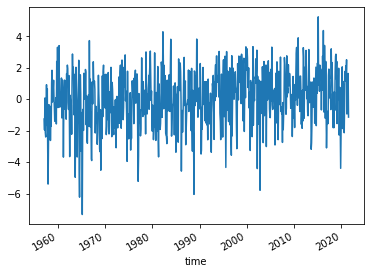

In [55]:
no_seas.plot();

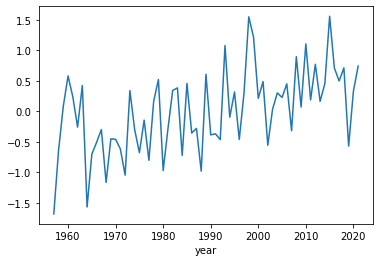

In [56]:
no_seas.groupby('time.year').mean().plot();

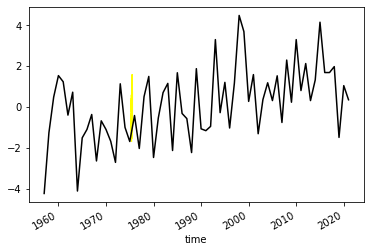

In [57]:
no_seas.groupby('time.year').mean().plot(color='yellow')
ann_seas.ANN.plot(color='k');

In [58]:
ann_seas.ANN

time
1957-01-01   -4.24
1958-01-01   -1.27
1959-01-01    0.47
1960-01-01    1.52
1961-01-01    1.22
              ... 
2017-01-01    1.67
2018-01-01    1.96
2019-01-01   -1.50
2020-01-01    1.03
2021-01-01    0.34
Name: ANN, Length: 65, dtype: float64

In [59]:
seaice_no05.interp(time = mo_xr.time.sel(time=slice('2006', '2011')))

<xarray.DataArray 'SIarea' (time: 72, YC: 137, XC: 570)>
dask.array<transpose, shape=(72, 137, 570), dtype=float32, chunksize=(72, 137, 570), chunktype=numpy.ndarray>
Coordinates:
    Z        float32 -5.0
  * time     (time) datetime64[ns] 2006-01-31 2006-02-28 ... 2011-12-31
Dimensions without coordinates: YC, XC
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

In [60]:
ann_xr = ann_seas.ANN.to_xarray()

In [61]:
ann_xr.sel(time=slice('2006', '2011'))

<xarray.DataArray 'ANN' (time: 6)>
array([ 1.51, -0.77,  2.28,  0.22,  3.28,  0.79])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2007-01-01 ... 2011-01-01

In [62]:
mo_xr.sel(time=slice('2006', '2011'))

<xarray.DataArray (time: 72)>
array([ 0.56, -1.85,  1.66, -0.69,  2.28,  2.05,  1.61, -2.64, -0.26,
        1.79,  0.14,  1.34,  0.03,  2.36, -0.77, -0.33, -1.02, -0.65,
       -2.67, -0.28, -1.88, -0.86,  0.03,  2.8 ,  2.56,  1.09,  0.63,
       -0.81, -0.66,  3.  ,  0.23,  0.6 ,  0.46,  2.21,  1.03,  1.01,
        2.02,  0.94,  0.5 , -0.43, -0.14,  0.54, -0.13, -2.44, -0.78,
        1.47, -1.2 ,  1.09, -0.4 , -2.12,  0.04,  0.08,  1.51,  3.14,
        3.37,  1.24, -0.33,  3.19,  3.88,  0.25,  0.48,  0.87, -0.79,
        1.62,  1.37,  0.72, -1.52, -0.73, -1.79,  0.59, -1.41,  3.43])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-31 2006-02-28 ... 2011-12-31

In [63]:
seaice_no05.time

<xarray.DataArray 'time' (time: 366)>
array(['2006-01-01T00:00:00.000000000', '2006-01-06T00:00:00.000000000',
       '2006-01-11T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z        float32 -5.0
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [64]:
corr_si_timeinterp = xr.corr(seaice_no05.sum(['XC','YC']).interp(time = mo_xr.time.sel(time=slice('2006', '2011'))),
               mo_xr.sel(time=slice('2006', '2011')), dim='time').values
corr_si_timeinterp

array(-0.06064425)

In [65]:
corr_mo = xr.corr(seaice_no05.sum(['XC','YC']), mo_xr.sel(time=slice('2006', '2011')), dim='time').values
corr_mo

array(-0.09227309)

In [66]:
corr_ann = xr.corr(seaice_no05.sum(['XC','YC']), ann_xr.sel(time=slice('2006', '2011')), dim='time').values
corr_ann

array(0.8412394)

### **SOSE's sea ice extent is strongly correlated with SAM index between 2006 through 2010**

## Saving Data

In [58]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [59]:
seaice_file1 = seaice.to_dataset(name='seaice')
seaice_file2 = seaice_no05.to_dataset(name='seaice_no05')
sose_si_index = si_index.to_dataset(name='sose_si_index')

In [81]:
seaice_file2

<xarray.Dataset>
Dimensions:      (XC: 570, YC: 95, time: 366)
Coordinates:
  * time         (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    Z            float32 -5.0
Dimensions without coordinates: XC, YC
Data variables:
    seaice_no05  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>

In [85]:
#uploading seaice WITH polynya year
gcsmap_seaice1 = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/seaicefiles/seaice.zarr')
seaice_file1.to_zarr(gcsmap_seaice1, mode='w')

In [84]:
#uploading seaice WITHOUT polynya year
gcsmap_seaice2 = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/seaicefiles/seaice_no05.zarr')
seaice_file2.to_zarr(gcsmap_seaice2, mode='w')

In [66]:
#uploading sose seaice index
gcsmap_si_index = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/seaicefiles/sose_si_index.zarr')
sose_si_index.to_zarr(gcsmap_si_index, mode='w')

## Timeseries

In [6]:
sose = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/seaicefiles/sose_si_index.zarr'))
sam = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/SAM-index/sam_mo_anom')
enso = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/ENSO-index/oni')

In [7]:
sose_resampled = sose.sose_si_index.resample(time='MS').mean()

In [8]:
sose_resampled

<xarray.DataArray 'sose_si_index' (time: 60)>
dask.array<stack, shape=(60,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2010-12-01
    Z        float32 ...

In [9]:
enso.sel(time=slice('2006', '2010'))

<xarray.DataArray 'sst' (time: 60)>
array([-0.703412, -0.627783, -0.392023, -0.160018,  0.099242,  0.199537,
        0.314816,  0.494516,  0.716087,  0.944376,  1.116996,  1.096937,
        0.789994,  0.356859,  0.056347, -0.107549, -0.145586, -0.24464 ,
       -0.344647, -0.616876, -0.893393, -1.163648, -1.32647 , -1.443807,
       -1.508408, -1.379251, -1.111469, -0.800557, -0.604031, -0.381658,
       -0.161126, -0.037749, -0.064222, -0.173256, -0.382123, -0.581808,
       -0.712964, -0.653422, -0.436618, -0.116823,  0.241748,  0.511523,
        0.66329 ,  0.765394,  0.891021,  1.186603,  1.529916,  1.717495,
        1.630411,  1.357513,  1.020135,  0.569341,  0.064116, -0.428062,
       -0.833754, -1.156375, -1.372571, -1.459237, -1.470133, -1.439778],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2010-12-01
    month    (time) int64 ...

In [10]:
sam_sliced = sam.sel(time=slice('2005', '2010')).assign_coords(coords={'time':enso.sel(time=slice('2005', '2010')).time})
sam_sliced

<xarray.DataArray (time: 72)>
array([ 0.682308,  1.906154, -0.114462,  3.310154, -0.356308, -0.653538,
       -0.580154,  0.564531,  0.327344, -0.132969,  0.681406, -2.91375 ,
        0.172308, -1.533846,  1.665538, -0.839846,  2.373692,  1.806462,
        1.529846, -2.575469, -0.322656,  1.767031,  0.161406,  1.18625 ,
       -0.357692,  2.676154, -0.764462, -0.479846, -0.926308, -0.893538,
       -2.750154, -0.215469, -1.942656, -0.882969,  0.051406,  2.64625 ,
        2.172308,  1.406154,  0.635538, -0.959846, -0.566308,  2.756462,
        0.149846,  0.664531,  0.397344,  2.187031,  1.051406,  0.85625 ,
        1.632308,  1.256154,  0.505538, -0.579846, -0.046308,  0.296462,
       -0.210154, -2.375469, -0.842656,  1.447031, -1.178594,  0.93625 ,
       -0.787692, -1.803846,  0.045538, -0.069846,  1.603692,  2.896462,
        3.289846,  1.304531, -0.392656,  3.167031,  3.901406,  0.09625 ])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01 2005-02-01 ... 2010-12-01
    month    (time) int64 ...

In [11]:
sam_sose_time = sam_sliced.groupby('time.year').mean().load()
sam_sose_time

<xarray.DataArray (year: 6)>
array([ 0.22672636,  0.44922636, -0.3199403 ,  0.89589303,  0.0700597 ,
        1.10422636])
Coordinates:
  * year     (year) int64 2005 2006 2007 2008 2009 2010

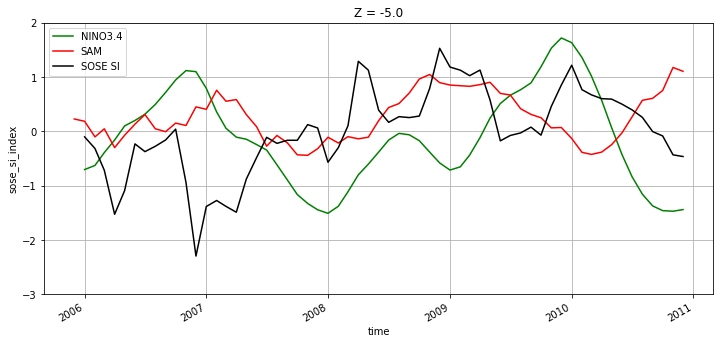

In [12]:
plt.figure(figsize=(12,5))
enso.sel(time=slice('2006', '2010')).plot(color='green', label='NINO3.4')
sam_sliced.rolling(time=12).mean().plot(color='red', label='SAM')
sose_resampled.plot(color='k', label='SOSE SI')
plt.legend()
plt.grid()
plt.ylim(-3,2); #ylims with 12-mth rolling mean
#plt.ylim(-3,4) #ylims without 12-mth rolling mean;
#plt.xlim('2006', '2010');

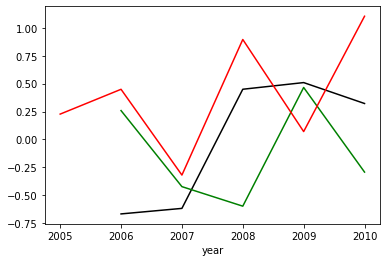

In [13]:
sose.sose_si_index.groupby('time.year').mean().plot(color='k')
enso.sel(time=slice('2006', '2010')).groupby('time.year').mean().plot(color='green')
sam_sose_time.plot(color='red');

## Butterworth filter

In [14]:
from scipy import signal
from scipy import fft

In [ ]:
fft.fft()

In [15]:
ps = np.square(np.abs(fft.fft(sose_resampled.values)))

In [16]:
ps.shape

(60,)

In [17]:
sose_resampled.shape

(60,)

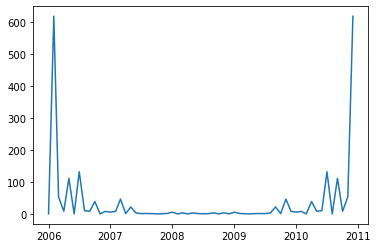

In [31]:
plt.plot(sose_resampled.time, ps)

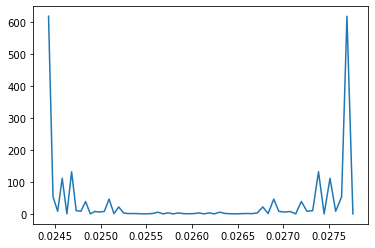

In [18]:
plt.plot(((1/sose_resampled.time.astype('int64'))*3.154e16), ps) #nanosc to yr

In [18]:
1/.0245

40.816326530612244

In [21]:
sose_resampled.time.astype('int64')[0]

<xarray.DataArray 'time' ()>
array(1136073600000000000)
Coordinates:
    time     datetime64[ns] 2006-01-01
    Z        float32 ...

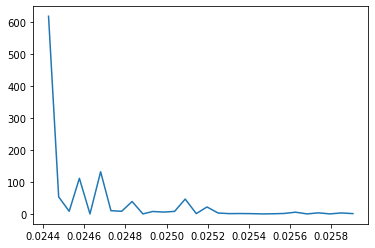

In [20]:
#just first half since last half should be in negative time space
plt.plot(((1/sose_resampled.time.astype('int64')) * 3.154e16)[31:], ps[31:]) 

In [21]:
signal.welch(sose_resampled) #[0] sample freq, [1] psd/power spectrum

/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  warnings.warn('nperseg = {0:d} is greater than input length '


(array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
        0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
        0.16666667, 0.18333333, 0.2       , 0.21666667, 0.23333333,
        0.25      , 0.26666667, 0.28333333, 0.3       , 0.31666667,
        0.33333333, 0.35      , 0.36666667, 0.38333333, 0.4       ,
        0.41666667, 0.43333333, 0.45      , 0.46666667, 0.48333333,
        0.5       ]),
 array([1.7918559e+00, 1.3655674e+01, 5.1332841e+00, 7.2076172e-02,
        1.9840304e+00, 4.8377118e-01, 3.6171401e+00, 1.7838279e+00,
        5.7483232e-01, 8.5218585e-01, 4.6199688e-01, 3.4927988e-01,
        4.9723220e-01, 3.5859525e-01, 9.3969637e-01, 4.2243019e-01,
        4.7141200e-01, 8.6766124e-02, 3.7318144e-03, 2.9739289e-02,
        2.7741676e-02, 3.0325702e-03, 1.3153023e-03, 3.6533970e-02,
        1.1231160e-01, 7.1103141e-02, 6.9804788e-02, 4.4864528e-03,
        1.0718167e-01, 5.1207699e-02, 9.3733508e-04], dtype=float32))

In [22]:
freq = signal.welch(sose_resampled)[0]
psd = signal.welch(sose_resampled)[1]
psd

/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  warnings.warn('nperseg = {0:d} is greater than input length '
/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  warnings.warn('nperseg = {0:d} is greater than input length '


array([1.7918559e+00, 1.3655674e+01, 5.1332841e+00, 7.2076172e-02,
       1.9840304e+00, 4.8377118e-01, 3.6171401e+00, 1.7838279e+00,
       5.7483232e-01, 8.5218585e-01, 4.6199688e-01, 3.4927988e-01,
       4.9723220e-01, 3.5859525e-01, 9.3969637e-01, 4.2243019e-01,
       4.7141200e-01, 8.6766124e-02, 3.7318144e-03, 2.9739289e-02,
       2.7741676e-02, 3.0325702e-03, 1.3153023e-03, 3.6533970e-02,
       1.1231160e-01, 7.1103141e-02, 6.9804788e-02, 4.4864528e-03,
       1.0718167e-01, 5.1207699e-02, 9.3733508e-04], dtype=float32)

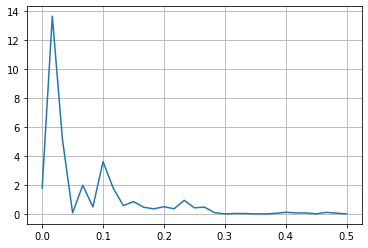

In [30]:
plt.plot(freq, psd)
plt.grid()

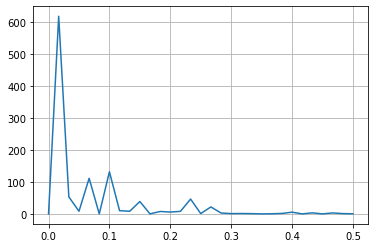

In [24]:
plt.plot(freq, ps[:31]) #strongest variability is a 5-yr cycle
plt.grid()
#3rd strongest variablity is a 1-yr cycle (annual cycle)
#second strongest variablity (3rd peak) is a 10-mth cycle - refer to Xiaojun's paper on export corr w SAM

In [74]:
1/9.98382866e-02

10.016197533582272

In [63]:
freq[ps[:31]==ps[:31].max()]

array([0.01666667])

In [69]:
ps

array([2.68420787e-03, 6.19128906e+02, 5.34698601e+01, 8.32975197e+00,
       1.11557983e+02, 9.52711254e-02, 1.32021606e+02, 1.01768255e+01,
       8.33839417e+00, 3.88783379e+01, 9.98382866e-02, 7.65689182e+00,
       5.80679941e+00, 7.96744156e+00, 4.65176659e+01, 1.04290164e+00,
       2.18447666e+01, 2.86963797e+00, 1.00151026e+00, 1.25251389e+00,
       9.10170913e-01, 5.98842464e-02, 5.44777513e-01, 1.46690989e+00,
       5.44908714e+00, 1.11251235e-01, 3.36438322e+00, 1.13649286e-01,
       3.10058713e+00, 9.81125832e-01, 4.76145476e-01, 9.81125832e-01,
       3.10058713e+00, 1.13649286e-01, 3.36438322e+00, 1.11251235e-01,
       5.44908714e+00, 1.46690989e+00, 5.44777513e-01, 5.98842464e-02,
       9.10170913e-01, 1.25251389e+00, 1.00151026e+00, 2.86963797e+00,
       2.18447666e+01, 1.04290164e+00, 4.65176659e+01, 7.96744156e+00,
       5.80679941e+00, 7.65689182e+00, 9.98382866e-02, 3.88783379e+01,
       8.33839417e+00, 1.01768255e+01, 1.32021606e+02, 9.52711254e-02,
      

In [68]:
freq[ps[:31]==100]

array([], dtype=float64)

In [64]:
1/0.01666667

59.999988000002396

In [65]:
60/12

5.0

In [67]:
1/.1

10.0

In [78]:
1/3

0.3333333333333333

In [98]:
signal.butter(3, (1/3))

(array([0.06385592, 0.19156777, 0.19156777, 0.06385592]),
 array([ 1.        , -0.96577971,  0.58264417, -0.10601706]))

In [32]:
#width of peak of bell curve is 3 so freq is 1/3
coeff = signal.butter(3, (1/3))[0] / signal.butter(3, (1/3))[1] #b/a
coeff

array([ 0.06385592, -0.19835556,  0.32879034, -0.60231746])

In [35]:
#output=Second-order sections representation of the IIR filter to avoid numerical error with transfer function (ba) format
#from signal.butter example doc
signal.butter(3, (1/3), output='sos') 

array([[ 0.06385592,  0.12771185,  0.06385592,  1.        , -0.26794919,
         0.        ],
       [ 1.        ,  1.        ,  0.        ,  1.        , -0.69783052,
         0.39566104]])

In [41]:
filt_sose = signal.sosfilt(signal.butter(3, (1/3), output='sos'), sose_resampled)
filt_sose

array([-0.00653902, -0.04613002, -0.16669714, -0.43665012, -0.84890771,
       -1.14480918, -1.03175759, -0.62258447, -0.2708335 , -0.11274704,
       -0.11741195, -0.40526901, -1.04017483, -1.62674611, -1.75154015,
       -1.54578145, -1.33183459, -1.1436462 , -0.85501   , -0.48424041,
       -0.19564935, -0.0890961 , -0.09285352, -0.07311478, -0.03751028,
       -0.11213139, -0.25040699, -0.17261612,  0.28626037,  0.84417098,
        1.01309779,  0.71219463,  0.31133858,  0.12163968,  0.18130772,
        0.45574575,  0.88445559,  1.24904577,  1.3440591 ,  1.22302051,
        1.05112441,  0.82588053,  0.45920859,  0.06068838, -0.14783344,
       -0.12966928, -0.00392765,  0.18990597,  0.49614608,  0.84218537,
        1.02108708,  0.93928529,  0.73189728,  0.57107019,  0.49729731,
        0.45065157,  0.36241141,  0.20805441,  0.0088738 , -0.20347455])

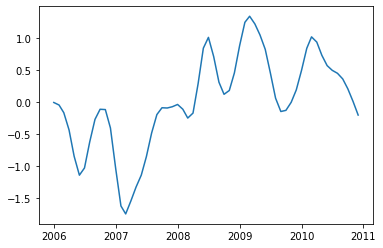

In [42]:
plt.plot(sose_resampled.time, filt_sose) #SUCCESS - took out high-freq stuff

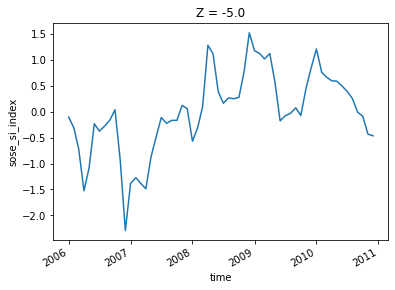

In [39]:
sose_resampled.plot()

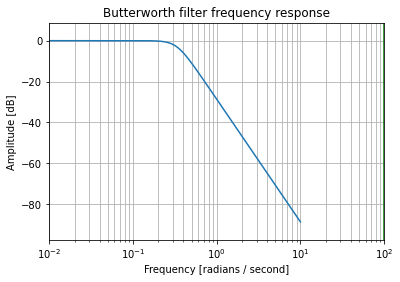

In [40]:
#This is what your filter looks like with inputs 3, (1/3)
b, a = signal.butter(3, (1/3), 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [52]:
filt_sam = signal.sosfilt(signal.butter(3, (1/3), output='sos'), sam_sliced[12:])
filt_enso = signal.sosfilt(signal.butter(3, (1/3), output='sos'), enso.sel(time=slice('2006', '2010')))

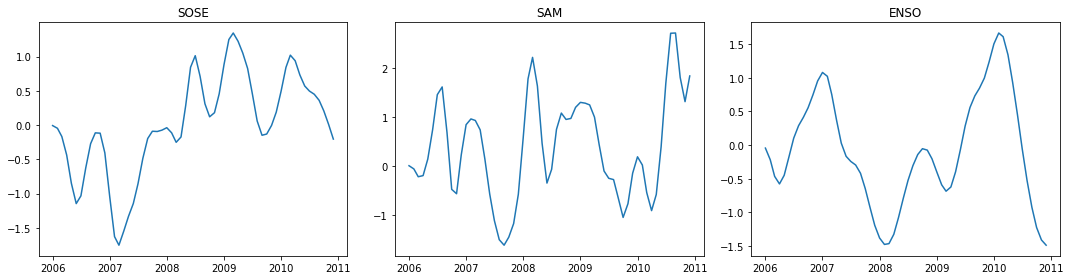

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

ax[0].plot(sose_resampled.time, filt_sose)
ax[0].set_title('SOSE')
ax[1].plot(sose_resampled.time, filt_sam)
ax[1].set_title('SAM')
ax[2].plot(sose_resampled.time, filt_enso)
ax[2].set_title('ENSO')
plt.tight_layout();

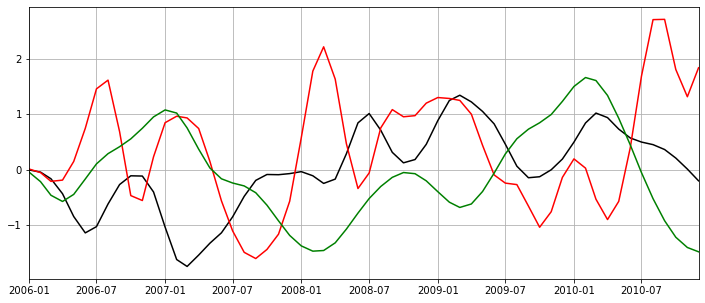

In [63]:
plt.figure(figsize=(12,5))
plt.plot(sose_resampled.time, filt_sose, color='k')
plt.plot(sose_resampled.time, filt_sam, color='r')
plt.plot(sose_resampled.time, filt_enso, color='g')
plt.xlim(sose_resampled.time[0], sose_resampled.time[-1])
plt.grid();